In [1]:
import pandas as pd
import polars as pl
import numpy as np
import clickhouse_connect as connect
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from hdbscan import HDBSCAN
import seaborn as sns

In [2]:
params = {
    'host': 'localhost',
    'port': '8123',
    'username': 'default',
    'password': 'default',
    'database': 'db_1'
}

client = connect.get_client(**params)

In [ ]:
client.query_df(
    '''
    select * from users
    limit 10
    ''')

,user_id,number_of_sessions,most_viewed_category_code,most_viewed_brand,times_purchased,times_carted,time_since_last_event,total_spend
0,122384079,9,appliances.kitchen.juicer,scarlett,0,0,2,0.0
1,143970484,1,electronics.video.tv,lg,0,0,7,0.0
2,153489867,4,electronics.tablet,huawei,0,0,17,0.0
3,170615748,1,MISSING,MISSING,0,0,16,0.0
4,183503497,1,MISSING,MISSING,0,0,29,0.0
5,184265397,6,furniture.living_room.chair,joie,0,0,16,0.0
6,191365178,52,appliances.kitchen.hob,electrolux,0,0,4,0.0
7,191943775,1,MISSING,sokolov,0,0,22,0.0
8,195082191,1,electronics.audio.headphone,apple,0,0,21,0.0
9,200673532,4,computers.components.videocards,asrock,0,0,18,0.0


In [ ]:
df = client.query_df('''
                     select * from users
                     ''')
df.head()

,user_id,number_of_sessions,most_viewed_category_code,most_viewed_brand,times_purchased,times_carted,time_since_last_event,total_spend
0,566869055,11,computers.components.videocards,sapphire,0,0,22,0.0
1,566869059,4,electronics.tablet,apple,0,0,25,0.0
2,566869062,15,auto.accessories.videoregister,ibox,0,0,19,0.0
3,566869079,8,MISSING,weifeng,0,0,28,0.0
4,566869083,2,electronics.smartphone,apple,0,0,28,0.0


In [ ]:
print('Количество уникальных значений в категориальных колонках:')
cat_cols = ['most_viewed_category_code', 'most_viewed_brand']
for c in cat_cols:
    print(f'{c}: {df[c].nunique()}')

Количество уникальных значений в категориальных колонках:
most_viewed_category_code: 130
most_viewed_brand: 3809


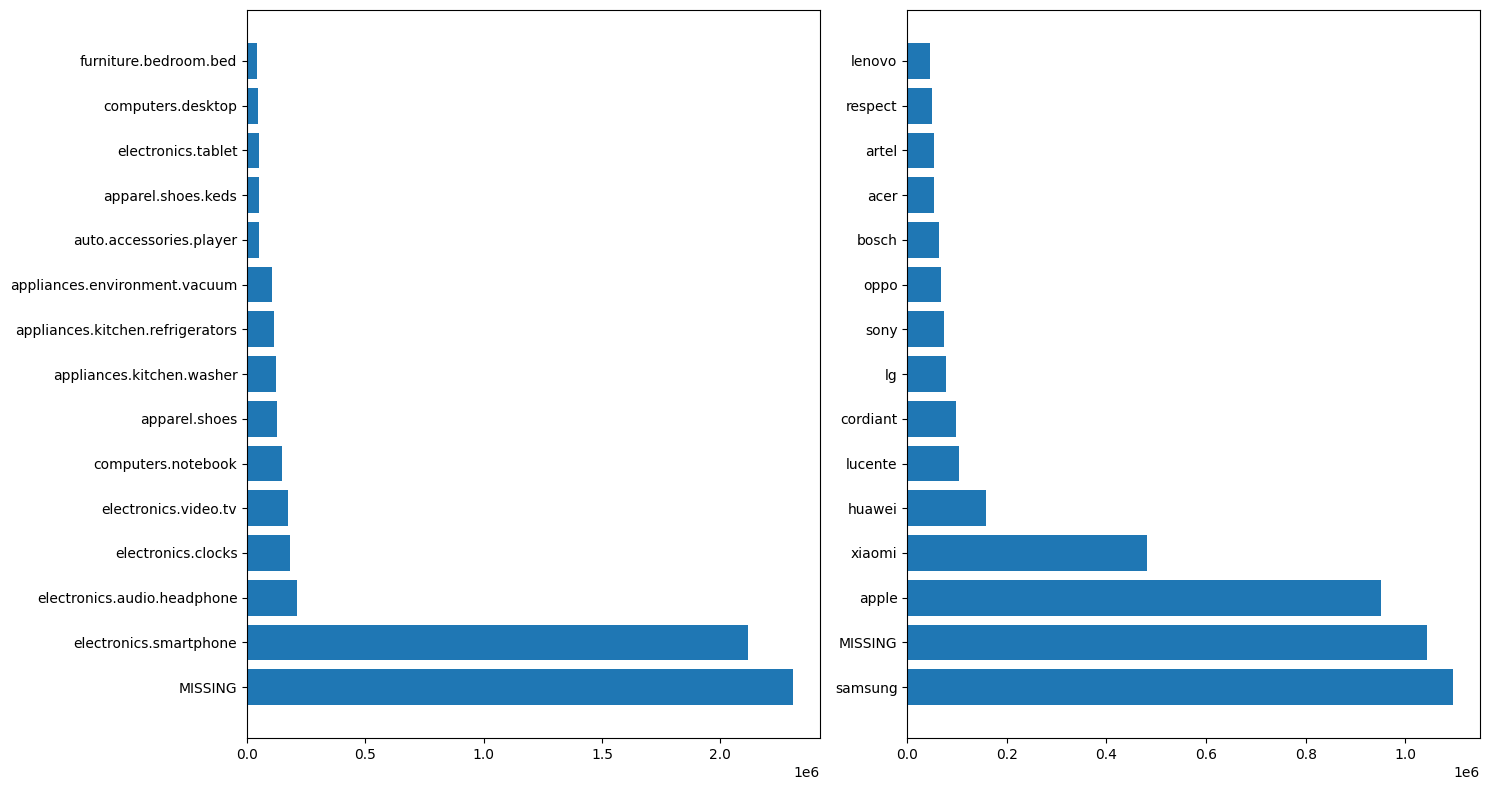

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
axes.ravel()
for i, c in enumerate(cat_cols):
    cnt = df[c].value_counts().sort_values(ascending=False).reset_index()
    axes[i].barh(cnt.iloc[:15, 0], cnt.iloc[:15, 1])
    #axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
def encode_category(df):
    df['category'] = df['most_viewed_category_code'].apply(lambda x: x.split('.')[0])
    df = df.drop('most_viewed_category_code', axis=1)
    return df
df = encode_category(df)
df['category'].value_counts()

category
electronics     2819419
MISSING         2305284
appliances       619373
computers        290453
apparel          231617
furniture        137718
auto             105924
kids              91252
construction      73958
sport             21487
accessories       17534
medicine           1917
stationery         1267
country_yard       1204
Name: count, dtype: int64

In [ ]:
def process_columns(df, c, map_string='brand'):
    cnt = df[c].value_counts().sort_values(ascending=False).reset_index()[:20]
    col_mapping = set(cnt.iloc[:, 0])
    df[c] = df[c].apply(lambda x: x if x in col_mapping else f'niche {map_string}')
    return df

df = process_columns(df, 'most_viewed_brand', 'brand')
df.head()

,user_id,number_of_sessions,most_viewed_brand,times_purchased,times_carted,time_since_last_event,total_spend,category
0,122384079,9,niche brand,0,0,2,0.0,appliances
1,143970484,1,lg,0,0,7,0.0,electronics
2,153489867,4,huawei,0,0,17,0.0,electronics
3,170615748,1,MISSING,0,0,16,0.0,MISSING
4,183503497,1,MISSING,0,0,29,0.0,MISSING


In [ ]:
cat_cols = ['category', 'most_viewed_brand']
def preprocess(df, cat_cols):
    for c in cat_cols:
        dummies = pd.get_dummies(df[c], prefix=f'{c}', drop_first=True, dtype=int)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(c, axis=1)
    return df

df_enc = preprocess(df, cat_cols)
df_enc.head()

,user_id,number_of_sessions,times_purchased,times_carted,time_since_last_event,total_spend,category_accessories,category_apparel,category_appliances,category_auto,...,most_viewed_brand_lg,most_viewed_brand_lucente,most_viewed_brand_niche brand,most_viewed_brand_oppo,most_viewed_brand_redmond,most_viewed_brand_respect,most_viewed_brand_samsung,most_viewed_brand_sony,most_viewed_brand_stels,most_viewed_brand_xiaomi
0,122384079,9,0,0,2,0.0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,143970484,1,0,0,7,0.0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,153489867,4,0,0,17,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,170615748,1,0,0,16,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,183503497,1,0,0,29,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Sampling**

In [3]:
df = client.query_df('''
                     select * from users
                     ''')
df.head()

,user_id,number_of_sessions,most_viewed_category_code,most_viewed_brand,times_purchased,times_carted,time_since_last_event,total_spend
0,562163470,33,appliances.kitchen.hob,bosch,0,0,0,0.000000
1,562163482,41,electronics.smartphone,samsung,2,3,2,388.820007
2,562163488,10,electronics.smartphone,xiaomi,0,0,10,0.000000
3,562163497,2,MISSING,omron,0,0,10,0.000000
4,562163499,2,electronics.smartphone,samsung,0,0,11,0.000000


(0.0, 2000.0)

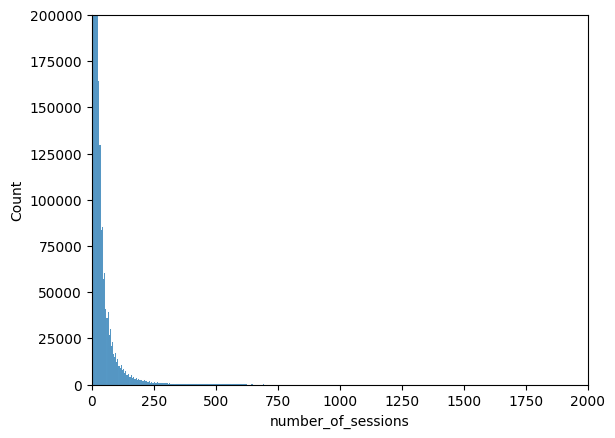

In [ ]:
col = 'number_of_sessions'
sns.histplot(data=df, x=col)
plt.ylim(0, 200_000)
plt.xlim(0, 2000)

(0.0, 50000.0)

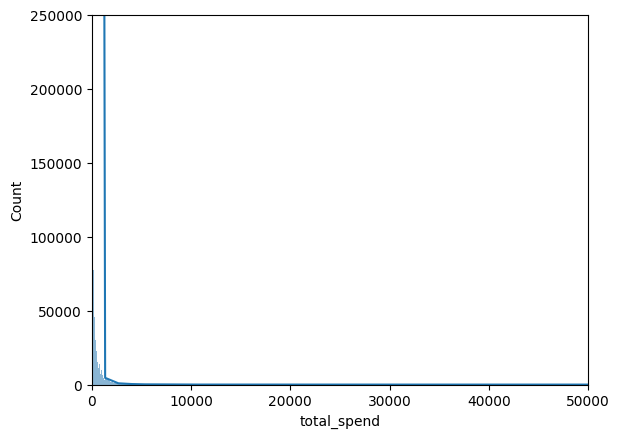

In [ ]:
col = 'total_spend'
sns.histplot(data=df, x=col, kde=True)
plt.ylim(0, 250_000)
plt.xlim(0, 50_000)

(0.0, 1200.0)

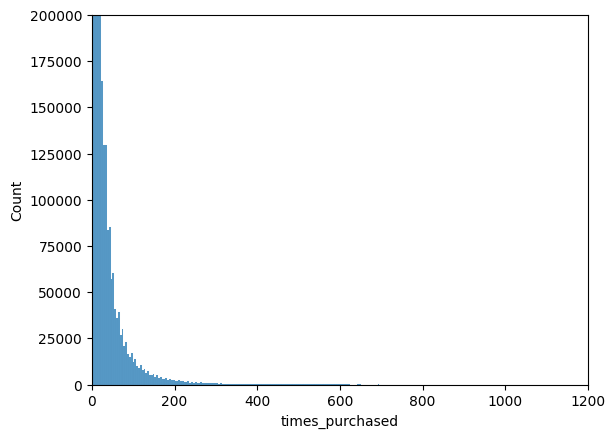

In [ ]:
col = 'times_purchased'
sns.histplot(data=df, x=col)
plt.ylim(0, 200000)
plt.xlim(0, 1200)

In [ ]:
print(df[df['number_of_sessions'] < 10].count() / df.shape[0] * 100)

user_id                      65.296997
number_of_sessions           65.296997
most_viewed_category_code    65.296997
most_viewed_brand            65.296997
times_purchased              65.296997
times_carted                 65.296997
time_since_last_event        65.296997
total_spend                  65.296997
dtype: float64


In [ ]:
print(df[df['total_spend'] == 0].count() / df.shape[0] * 100)

user_id                      88.259776
number_of_sessions           88.259776
most_viewed_category_code    88.259776
most_viewed_brand            88.259776
times_purchased              88.259776
times_carted                 88.259776
time_since_last_event        88.259776
total_spend                  88.259776
dtype: float64


In [ ]:
df.columns

Index(['user_id', 'number_of_sessions', 'most_viewed_category_code',
       'most_viewed_brand', 'times_purchased', 'times_carted',
       'time_since_last_event', 'total_spend'],
      dtype='object')

In [ ]:
df.shape

(6718407, 8)

In [ ]:
df.describe()

,number_of_sessions,times_purchased,times_carted,time_since_last_event,total_spend
count,6.718407e+06,6.718407e+06,6.718407e+06,6.718407e+06,6.718407e+06
mean,1.636560e+01,2.470508e-01,5.887476e-01,1.179101e+01,7.518931e+01
std,4.028451e+01,1.368453e+00,2.563965e+00,8.558461e+00,6.649579e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00
50%,5.000000e+00,0.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00
75%,1.500000e+01,0.000000e+00,0.000000e+00,1.800000e+01,0.000000e+00
max,2.292900e+04,5.190000e+02,7.190000e+02,3.000000e+01,2.655695e+05


In [4]:
conditions = [
    (df['number_of_sessions'] < 5) & (df['times_purchased'] == 0),
    (df['number_of_sessions'] >= 5) & (df['times_purchased'] == 0),
    (df['number_of_sessions'] < 5) & (df['times_purchased'] > 0),
    (df['times_purchased'] > 0)

]

states = [
    'non-active',
    'active',
    'instant buyer',
    'buyer'
]

df['activity'] = np.select(conditions, states, default='unknown')
df.head()

,user_id,number_of_sessions,most_viewed_category_code,most_viewed_brand,times_purchased,times_carted,time_since_last_event,total_spend,activity
0,562163470,33,appliances.kitchen.hob,bosch,0,0,0,0.000000,active
1,562163482,41,electronics.smartphone,samsung,2,3,2,388.820007,buyer
2,562163488,10,electronics.smartphone,xiaomi,0,0,10,0.000000,active
3,562163497,2,MISSING,omron,0,0,10,0.000000,non-active
4,562163499,2,electronics.smartphone,samsung,0,0,11,0.000000,non-active


In [20]:
tmp = df[df['activity'] != 'non-active']
sample = tmp.groupby('activity', group_keys=False).apply(lambda x: x.sample(frac=0.05))
sample.head()

C:\Users\danil\AppData\Local\Temp\ipykernel_1912\2846543161.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = tmp.groupby('activity', group_keys=False).apply(lambda x: x.sample(frac=0.05))


,user_id,number_of_sessions,most_viewed_category_code,most_viewed_brand,times_purchased,times_carted,time_since_last_event,total_spend,activity
60974,532360401,17,MISSING,lucente,0,0,22,0.0,active
279521,529809192,8,MISSING,hankook,0,0,13,0.0,active
2131679,513300725,13,electronics.tablet,samsung,0,0,2,0.0,active
839265,512626414,16,MISSING,janome,0,0,0,0.0,active
800129,562922509,9,computers.notebook,xiaomi,0,0,8,0.0,active


In [21]:
sample.groupby('activity').count()

,user_id,number_of_sessions,most_viewed_category_code,most_viewed_brand,times_purchased,times_carted,time_since_last_event,total_spend
activity,,,,,,,,
active,137814,137814,137814,137814,137814,137814,137814,137814
buyer,36434,36434,36434,36434,36434,36434,36434,36434
instant buyer,3004,3004,3004,3004,3004,3004,3004,3004


In [22]:
sample['log_sessions'] = np.log1p(sample['number_of_sessions'])
sample['log_purchased'] = np.log1p(sample['times_purchased'])
sample['log_carted'] = np.log1p(sample['times_carted'])
sample['log_spend'] = np.log1p(sample['total_spend'])
analysis = sample.drop(['times_purchased', 'number_of_sessions', 'times_carted', 'total_spend'], axis=1)
analysis.head()

,user_id,most_viewed_category_code,most_viewed_brand,time_since_last_event,activity,log_sessions,log_purchased,log_carted,log_spend
60974,532360401,MISSING,lucente,22,active,2.890372,0.0,0.0,0.0
279521,529809192,MISSING,hankook,13,active,2.197225,0.0,0.0,0.0
2131679,513300725,electronics.tablet,samsung,2,active,2.639057,0.0,0.0,0.0
839265,512626414,MISSING,janome,0,active,2.833213,0.0,0.0,0.0
800129,562922509,computers.notebook,xiaomi,8,active,2.302585,0.0,0.0,0.0


In [8]:
analysis.shape

(177252, 9)

In [23]:
dbscan = HDBSCAN(min_cluster_size=100, min_samples=50, cluster_selection_epsilon=0.1, gen_min_span_tree=True, prediction_data=True)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(analysis.drop(['activity', 'user_id', 'most_viewed_category_code', 'most_viewed_brand', ], axis=1))
dbscan.fit(scaled)

,min_cluster_size,100
,min_samples,50
,cluster_selection_epsilon,0.1
,cluster_selection_persistence,0.0
,max_cluster_size,0
,metric,'euclidean'
,alpha,1.0
,p,None
,algorithm,'best'
,leaf_size,40
,memory,Memory(location=None)


d:\eCommerce\venv\Lib\site-packages\matplotlib\transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


<Axes: ylabel='$\\lambda$ value'>

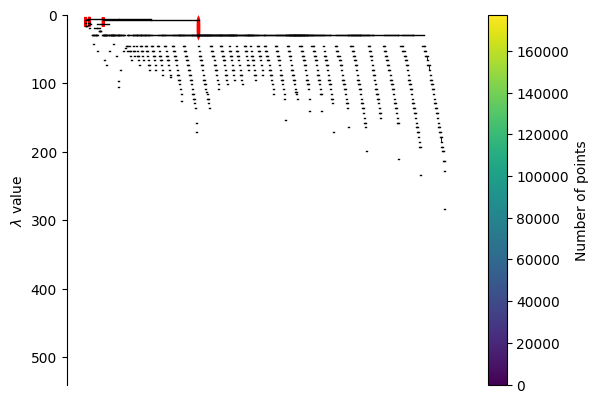

In [24]:
dbscan.condensed_tree_.plot(select_clusters=True)

In [79]:
dbscan.relative_validity_

np.float64(0.002005242992079332)

In [11]:
import optuna
from sklearn.metrics import silhouette_score

def objective(trial: optuna.trial):
    params = {
    'min_cluster_size': trial.suggest_int('min_cluster_size', 50, 6000),
    'min_samples': trial.suggest_int('min_samples', 10, 500),
    'cluster_selection_epsilon': trial.suggest_float('cluster_selection_epsilon', 0, 0.4),
    'memory': './hdbscan_cache',
    'gen_min_span_tree': True
    }
    cluster = HDBSCAN(**params)

    try:
        cluster.fit(scaled)
        labels = cluster.labels_
    except ValueError:
        return -1.0
    
    n_clusters = labels.max()
    noise_ratio = (labels == -1).sum() / labels.shape[0]

    if n_clusters < 3 or n_clusters > 10:
        return -1.0
    
    if noise_ratio > 0.1:
        return -1.0
    
    score = cluster.relative_validity_

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)
print("Best params:", study.best_params)
print("Best score:", study.best_value)
best_params = study.best_params
final_model = HDBSCAN(**best_params, gen_min_span_tree=True).fit(scaled)

d:\eCommerce\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2026-01-21 19:19:51,173] A new study created in memory with name: no-name-200287c9-5c30-43bb-a03a-4490eb375591
Best trial: 0. Best value: -1:   2%|▏         | 1/50 [00:17<14:14, 17.44s/it]

[I 2026-01-21 19:20:08,617] Trial 0 finished with value: -1.0 and parameters: {'min_cluster_size': 2549, 'min_samples': 41, 'cluster_selection_epsilon': 0.18392067795789546}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:   4%|▍         | 2/50 [00:47<19:49, 24.79s/it]

[I 2026-01-21 19:20:38,543] Trial 1 finished with value: -1.0 and parameters: {'min_cluster_size': 2493, 'min_samples': 491, 'cluster_selection_epsilon': 0.23814221548490813}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:   6%|▌         | 3/50 [01:08<18:14, 23.29s/it]

[I 2026-01-21 19:21:00,057] Trial 2 finished with value: -1.0 and parameters: {'min_cluster_size': 204, 'min_samples': 194, 'cluster_selection_epsilon': 0.006031719386682389}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:   8%|▊         | 4/50 [01:37<19:20, 25.23s/it]

[I 2026-01-21 19:21:28,264] Trial 3 finished with value: -1.0 and parameters: {'min_cluster_size': 5082, 'min_samples': 470, 'cluster_selection_epsilon': 0.11097644531960822}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:  10%|█         | 5/50 [01:59<18:09, 24.22s/it]

[I 2026-01-21 19:21:50,681] Trial 4 finished with value: -1.0 and parameters: {'min_cluster_size': 5721, 'min_samples': 257, 'cluster_selection_epsilon': 0.16260821911621937}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:  12%|█▏        | 6/50 [02:23<17:37, 24.03s/it]

[I 2026-01-21 19:22:14,350] Trial 5 finished with value: -1.0 and parameters: {'min_cluster_size': 3714, 'min_samples': 298, 'cluster_selection_epsilon': 0.019315027350367234}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:  14%|█▍        | 7/50 [02:47<17:18, 24.16s/it]

[I 2026-01-21 19:22:38,769] Trial 6 finished with value: -1.0 and parameters: {'min_cluster_size': 3686, 'min_samples': 339, 'cluster_selection_epsilon': 0.16524250331818272}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:  16%|█▌        | 8/50 [03:14<17:30, 25.01s/it]

[I 2026-01-21 19:23:05,604] Trial 7 finished with value: -1.0 and parameters: {'min_cluster_size': 1860, 'min_samples': 383, 'cluster_selection_epsilon': 0.3924029002853445}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:  18%|█▊        | 9/50 [03:36<16:26, 24.06s/it]

[I 2026-01-21 19:23:27,570] Trial 8 finished with value: -1.0 and parameters: {'min_cluster_size': 4304, 'min_samples': 230, 'cluster_selection_epsilon': 0.08650693273104584}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:  20%|██        | 10/50 [04:02<16:29, 24.74s/it]

[I 2026-01-21 19:23:53,848] Trial 9 finished with value: -1.0 and parameters: {'min_cluster_size': 5681, 'min_samples': 412, 'cluster_selection_epsilon': 0.35701321978164613}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:  22%|██▏       | 11/50 [04:19<14:35, 22.45s/it]

[I 2026-01-21 19:24:11,094] Trial 10 finished with value: -1.0 and parameters: {'min_cluster_size': 946, 'min_samples': 29, 'cluster_selection_epsilon': 0.27678261297914486}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:  24%|██▍       | 12/50 [04:36<13:01, 20.58s/it]

[I 2026-01-21 19:24:27,390] Trial 11 finished with value: -1.0 and parameters: {'min_cluster_size': 2322, 'min_samples': 13, 'cluster_selection_epsilon': 0.27692565302078115}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:  26%|██▌       | 13/50 [04:55<12:29, 20.27s/it]

[I 2026-01-21 19:24:46,950] Trial 12 finished with value: -1.0 and parameters: {'min_cluster_size': 2549, 'min_samples': 133, 'cluster_selection_epsilon': 0.24571852697584012}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:  28%|██▊       | 14/50 [05:15<12:02, 20.06s/it]

[I 2026-01-21 19:25:06,532] Trial 13 finished with value: -1.0 and parameters: {'min_cluster_size': 1369, 'min_samples': 118, 'cluster_selection_epsilon': 0.22457132639407862}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:  30%|███       | 15/50 [05:44<13:15, 22.74s/it]

[I 2026-01-21 19:25:35,467] Trial 14 finished with value: -1.0 and parameters: {'min_cluster_size': 3191, 'min_samples': 496, 'cluster_selection_epsilon': 0.18030299079187923}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:  32%|███▏      | 16/50 [06:02<12:09, 21.46s/it]

[I 2026-01-21 19:25:53,952] Trial 15 finished with value: -1.0 and parameters: {'min_cluster_size': 2634, 'min_samples': 89, 'cluster_selection_epsilon': 0.3235251115071055}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:  34%|███▍      | 17/50 [06:22<11:33, 21.00s/it]

[I 2026-01-21 19:26:13,905] Trial 16 finished with value: -1.0 and parameters: {'min_cluster_size': 1730, 'min_samples': 173, 'cluster_selection_epsilon': 0.11140886190374166}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:  36%|███▌      | 18/50 [06:51<12:30, 23.44s/it]

[I 2026-01-21 19:26:43,016] Trial 17 finished with value: -1.0 and parameters: {'min_cluster_size': 3345, 'min_samples': 416, 'cluster_selection_epsilon': 0.2116936468101678}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:  38%|███▊      | 19/50 [07:15<12:09, 23.53s/it]

[I 2026-01-21 19:27:06,762] Trial 18 finished with value: -1.0 and parameters: {'min_cluster_size': 4443, 'min_samples': 306, 'cluster_selection_epsilon': 0.30966262737686834}. Best is trial 0 with value: -1.0.


Best trial: 19. Best value: 0.0394416:  40%|████      | 20/50 [07:40<12:01, 24.05s/it]

[I 2026-01-21 19:27:32,014] Trial 19 finished with value: 0.03944161089919735 and parameters: {'min_cluster_size': 393, 'min_samples': 77, 'cluster_selection_epsilon': 0.0639824365820599}. Best is trial 19 with value: 0.03944161089919735.


Best trial: 19. Best value: 0.0394416:  42%|████▏     | 21/50 [08:06<11:48, 24.44s/it]

[I 2026-01-21 19:27:57,379] Trial 20 finished with value: 0.000875976382554151 and parameters: {'min_cluster_size': 540, 'min_samples': 66, 'cluster_selection_epsilon': 0.04980162741442415}. Best is trial 19 with value: 0.03944161089919735.


Best trial: 19. Best value: 0.0394416:  44%|████▍     | 22/50 [08:30<11:25, 24.50s/it]

[I 2026-01-21 19:28:22,004] Trial 21 finished with value: 0.00550104744945811 and parameters: {'min_cluster_size': 98, 'min_samples': 60, 'cluster_selection_epsilon': 0.05487559117488877}. Best is trial 19 with value: 0.03944161089919735.


Best trial: 19. Best value: 0.0394416:  46%|████▌     | 23/50 [08:56<11:12, 24.89s/it]

[I 2026-01-21 19:28:47,820] Trial 22 finished with value: 0.0019826705135021438 and parameters: {'min_cluster_size': 81, 'min_samples': 78, 'cluster_selection_epsilon': 0.05347010606570351}. Best is trial 19 with value: 0.03944161089919735.


Best trial: 19. Best value: 0.0394416:  48%|████▊     | 24/50 [09:17<10:13, 23.60s/it]

[I 2026-01-21 19:29:08,404] Trial 23 finished with value: -1.0 and parameters: {'min_cluster_size': 60, 'min_samples': 144, 'cluster_selection_epsilon': 0.05830008752488207}. Best is trial 19 with value: 0.03944161089919735.


Best trial: 19. Best value: 0.0394416:  50%|█████     | 25/50 [09:19<07:07, 17.11s/it]

[I 2026-01-21 19:29:10,365] Trial 24 finished with value: -1.0 and parameters: {'min_cluster_size': 852, 'min_samples': 89, 'cluster_selection_epsilon': 0.12791861156156567}. Best is trial 19 with value: 0.03944161089919735.


Best trial: 25. Best value: 0.189611:  52%|█████▏    | 26/50 [09:46<08:07, 20.31s/it] 

[I 2026-01-21 19:29:38,146] Trial 25 finished with value: 0.18961082143306573 and parameters: {'min_cluster_size': 1052, 'min_samples': 75, 'cluster_selection_epsilon': 0.04884147797792132}. Best is trial 25 with value: 0.18961082143306573.


Best trial: 25. Best value: 0.189611:  54%|█████▍    | 27/50 [10:08<07:55, 20.65s/it]

[I 2026-01-21 19:29:59,600] Trial 26 finished with value: -1.0 and parameters: {'min_cluster_size': 1168, 'min_samples': 178, 'cluster_selection_epsilon': 0.07666594314900278}. Best is trial 25 with value: 0.18961082143306573.


Best trial: 25. Best value: 0.189611:  56%|█████▌    | 28/50 [10:25<07:12, 19.65s/it]

[I 2026-01-21 19:30:16,923] Trial 27 finished with value: -1.0 and parameters: {'min_cluster_size': 561, 'min_samples': 45, 'cluster_selection_epsilon': 0.022559821825433406}. Best is trial 25 with value: 0.18961082143306573.


Best trial: 25. Best value: 0.189611:  58%|█████▊    | 29/50 [10:44<06:46, 19.36s/it]

[I 2026-01-21 19:30:35,598] Trial 28 finished with value: -1.0 and parameters: {'min_cluster_size': 1591, 'min_samples': 114, 'cluster_selection_epsilon': 0.13269954319123023}. Best is trial 25 with value: 0.18961082143306573.


Best trial: 25. Best value: 0.189611:  60%|██████    | 30/50 [11:03<06:22, 19.13s/it]

[I 2026-01-21 19:30:54,182] Trial 29 finished with value: -1.0 and parameters: {'min_cluster_size': 678, 'min_samples': 55, 'cluster_selection_epsilon': 0.07979774999753929}. Best is trial 25 with value: 0.18961082143306573.


Best trial: 25. Best value: 0.189611:  62%|██████▏   | 31/50 [11:27<06:34, 20.75s/it]

[I 2026-01-21 19:31:18,708] Trial 30 finished with value: 0.05681533979102125 and parameters: {'min_cluster_size': 2048, 'min_samples': 11, 'cluster_selection_epsilon': 0.0425660488491954}. Best is trial 25 with value: 0.18961082143306573.


Best trial: 31. Best value: 0.204367:  64%|██████▍   | 32/50 [11:52<06:34, 21.90s/it]

[I 2026-01-21 19:31:43,310] Trial 31 finished with value: 0.2043670701829906 and parameters: {'min_cluster_size': 1958, 'min_samples': 18, 'cluster_selection_epsilon': 0.035365975829678514}. Best is trial 31 with value: 0.2043670701829906.


Best trial: 31. Best value: 0.204367:  66%|██████▌   | 33/50 [11:53<04:29, 15.84s/it]

[I 2026-01-21 19:31:45,005] Trial 32 finished with value: -1.0 and parameters: {'min_cluster_size': 2113, 'min_samples': 18, 'cluster_selection_epsilon': 0.033158824776323814}. Best is trial 31 with value: 0.2043670701829906.


Best trial: 31. Best value: 0.204367:  68%|██████▊   | 34/50 [12:12<04:27, 16.71s/it]

[I 2026-01-21 19:32:03,734] Trial 33 finished with value: -1.0 and parameters: {'min_cluster_size': 1387, 'min_samples': 100, 'cluster_selection_epsilon': 0.006537006711273639}. Best is trial 31 with value: 0.2043670701829906.


Best trial: 31. Best value: 0.204367:  70%|███████   | 35/50 [12:36<04:45, 19.00s/it]

[I 2026-01-21 19:32:28,086] Trial 34 finished with value: 0.00782504836278136 and parameters: {'min_cluster_size': 2055, 'min_samples': 36, 'cluster_selection_epsilon': 0.08454232918674262}. Best is trial 31 with value: 0.2043670701829906.


Best trial: 31. Best value: 0.204367:  72%|███████▏  | 36/50 [12:56<04:29, 19.23s/it]

[I 2026-01-21 19:32:47,835] Trial 35 finished with value: -1.0 and parameters: {'min_cluster_size': 2760, 'min_samples': 153, 'cluster_selection_epsilon': 0.003283074366350433}. Best is trial 31 with value: 0.2043670701829906.


Best trial: 31. Best value: 0.204367:  74%|███████▍  | 37/50 [13:20<04:28, 20.69s/it]

[I 2026-01-21 19:33:11,930] Trial 36 finished with value: 0.0014021190282723045 and parameters: {'min_cluster_size': 1031, 'min_samples': 15, 'cluster_selection_epsilon': 0.034757631832123284}. Best is trial 31 with value: 0.2043670701829906.


Best trial: 31. Best value: 0.204367:  76%|███████▌  | 38/50 [13:42<04:12, 21.04s/it]

[I 2026-01-21 19:33:33,786] Trial 37 finished with value: -1.0 and parameters: {'min_cluster_size': 1398, 'min_samples': 206, 'cluster_selection_epsilon': 0.14174146799156223}. Best is trial 31 with value: 0.2043670701829906.


Best trial: 31. Best value: 0.204367:  78%|███████▊  | 39/50 [14:07<04:03, 22.10s/it]

[I 2026-01-21 19:33:58,364] Trial 38 finished with value: 0.16783349713311949 and parameters: {'min_cluster_size': 463, 'min_samples': 52, 'cluster_selection_epsilon': 0.10815731862662585}. Best is trial 31 with value: 0.2043670701829906.


Best trial: 31. Best value: 0.204367:  80%|████████  | 40/50 [14:23<03:25, 20.51s/it]

[I 2026-01-21 19:34:15,149] Trial 39 finished with value: -1.0 and parameters: {'min_cluster_size': 2036, 'min_samples': 49, 'cluster_selection_epsilon': 0.1061498956365865}. Best is trial 31 with value: 0.2043670701829906.


Best trial: 31. Best value: 0.204367:  82%|████████▏ | 41/50 [14:42<03:00, 20.04s/it]

[I 2026-01-21 19:34:34,093] Trial 40 finished with value: -1.0 and parameters: {'min_cluster_size': 1661, 'min_samples': 106, 'cluster_selection_epsilon': 0.10238334814435487}. Best is trial 31 with value: 0.2043670701829906.


Best trial: 31. Best value: 0.204367:  84%|████████▍ | 42/50 [15:00<02:34, 19.27s/it]

[I 2026-01-21 19:34:51,561] Trial 41 finished with value: -1.0 and parameters: {'min_cluster_size': 381, 'min_samples': 73, 'cluster_selection_epsilon': 0.06882455198175874}. Best is trial 31 with value: 0.2043670701829906.


Best trial: 31. Best value: 0.204367:  86%|████████▌ | 43/50 [15:25<02:26, 20.92s/it]

[I 2026-01-21 19:35:16,335] Trial 42 finished with value: 0.0012164687135579808 and parameters: {'min_cluster_size': 753, 'min_samples': 10, 'cluster_selection_epsilon': 0.03862982286809257}. Best is trial 31 with value: 0.2043670701829906.


Best trial: 31. Best value: 0.204367:  88%|████████▊ | 44/50 [15:43<02:00, 20.02s/it]

[I 2026-01-21 19:35:34,247] Trial 43 finished with value: -1.0 and parameters: {'min_cluster_size': 418, 'min_samples': 38, 'cluster_selection_epsilon': 0.019764451878104217}. Best is trial 31 with value: 0.2043670701829906.


Best trial: 31. Best value: 0.204367:  90%|█████████ | 45/50 [16:01<01:37, 19.59s/it]

[I 2026-01-21 19:35:52,845] Trial 44 finished with value: -1.0 and parameters: {'min_cluster_size': 1168, 'min_samples': 76, 'cluster_selection_epsilon': 0.10017645904170674}. Best is trial 31 with value: 0.2043670701829906.


Best trial: 31. Best value: 0.204367:  92%|█████████▏| 46/50 [16:21<01:18, 19.62s/it]

[I 2026-01-21 19:36:12,532] Trial 45 finished with value: -1.0 and parameters: {'min_cluster_size': 2970, 'min_samples': 134, 'cluster_selection_epsilon': 0.14718713023566854}. Best is trial 31 with value: 0.2043670701829906.


Best trial: 31. Best value: 0.204367:  94%|█████████▍| 47/50 [16:44<01:02, 20.71s/it]

[I 2026-01-21 19:36:35,774] Trial 46 finished with value: -1.0 and parameters: {'min_cluster_size': 2318, 'min_samples': 231, 'cluster_selection_epsilon': 0.06655420175233057}. Best is trial 31 with value: 0.2043670701829906.


Best trial: 31. Best value: 0.204367:  96%|█████████▌| 48/50 [17:09<00:44, 22.11s/it]

[I 2026-01-21 19:37:01,146] Trial 47 finished with value: 0.02662006719830055 and parameters: {'min_cluster_size': 941, 'min_samples': 44, 'cluster_selection_epsilon': 0.04100053530485792}. Best is trial 31 with value: 0.2043670701829906.


Best trial: 31. Best value: 0.204367:  98%|█████████▊| 49/50 [17:34<00:22, 22.89s/it]

[I 2026-01-21 19:37:25,878] Trial 48 finished with value: 0.13632736208257729 and parameters: {'min_cluster_size': 306, 'min_samples': 30, 'cluster_selection_epsilon': 0.09420037800938286}. Best is trial 31 with value: 0.2043670701829906.


Best trial: 31. Best value: 0.204367: 100%|██████████| 50/50 [17:52<00:00, 21.45s/it]


[I 2026-01-21 19:37:43,618] Trial 49 finished with value: -1.0 and parameters: {'min_cluster_size': 1303, 'min_samples': 27, 'cluster_selection_epsilon': 0.17160353163718456}. Best is trial 31 with value: 0.2043670701829906.
Best params: {'min_cluster_size': 1958, 'min_samples': 18, 'cluster_selection_epsilon': 0.035365975829678514}
Best score: 0.2043670701829906


In [12]:
import plotly
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice
plot_optimization_history(study).show()

plot_param_importances(study).show()

plot_slice(study).show()

In [17]:
from sklearn.metrics import adjusted_rand_score
from hdbscan import approximate_predict

tmp = df[df['activity'] != 'non-active']
sample = tmp.groupby('activity', group_keys=False).apply(lambda x: x.sample(frac=0.05))
sample['log_sessions'] = np.log1p(sample['number_of_sessions'])
sample['log_purchased'] = np.log1p(sample['times_purchased'])
sample['log_carted'] = np.log1p(sample['times_carted'])
sample['log_spend'] = np.log1p(sample['total_spend'])
sample_1 = sample.drop(['times_purchased', 'number_of_sessions', 'times_carted', 'total_spend'], axis=1)
sample = tmp.groupby('activity', group_keys=False).apply(lambda x: x.sample(frac=0.05))
sample['log_sessions'] = np.log1p(sample['number_of_sessions'])
sample['log_purchased'] = np.log1p(sample['times_purchased'])
sample['log_carted'] = np.log1p(sample['times_carted'])
sample['log_spend'] = np.log1p(sample['total_spend'])
sample_2 = sample.drop(['times_purchased', 'number_of_sessions', 'times_carted', 'total_spend'], axis=1)
sample = tmp.groupby('activity', group_keys=False).apply(lambda x: x.sample(frac=0.05))
sample['log_sessions'] = np.log1p(sample['number_of_sessions'])
sample['log_purchased'] = np.log1p(sample['times_purchased'])
sample['log_carted'] = np.log1p(sample['times_carted'])
sample['log_spend'] = np.log1p(sample['total_spend'])
sample_test = sample.drop(['times_purchased', 'number_of_sessions', 'times_carted', 'total_spend'], axis=1)

dbscan_1 = HDBSCAN(min_cluster_size=100, min_samples=50, cluster_selection_epsilon=0.1, prediction_data=True)
scaler_1 = MinMaxScaler()
scaled = scaler_1.fit_transform(sample_1.drop(['activity', 'user_id', 'most_viewed_category_code', 'most_viewed_brand', ], axis=1))
dbscan_1.fit(scaled)

dbscan_2 = HDBSCAN(min_cluster_size=100, min_samples=50, cluster_selection_epsilon=0.1, prediction_data=True)
scaler_2 = MinMaxScaler()
scaled = scaler_2.fit_transform(sample_2.drop(['activity', 'user_id', 'most_viewed_category_code', 'most_viewed_brand', ], axis=1))
dbscan_2.fit(scaled)

scaler_test = MinMaxScaler()
scaled_test = scaler_test.fit_transform(sample_test.drop(['activity', 'user_id', 'most_viewed_category_code', 'most_viewed_brand', ], axis=1))

labels_1, _ = approximate_predict(dbscan_1, scaled_test)
labels_2, _ = approximate_predict(dbscan_2, scaled_test)

adjusted_rand_score(labels_1, labels_2)

C:\Users\danil\AppData\Local\Temp\ipykernel_19324\1319920448.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = tmp.groupby('activity', group_keys=False).apply(lambda x: x.sample(frac=0.05))
C:\Users\danil\AppData\Local\Temp\ipykernel_19324\1319920448.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = tmp.groupby('activity', group_keys=False).apply(lambda x: x.sample(frac=0.05))
C:\Users\danil\Ap

0.6196173253875173

In [25]:
labels = dbscan.labels_

In [26]:
(labels == -1).sum() / labels.shape[0] * 100

np.float64(1.759641640150746)

In [27]:
labels.max()

np.int64(3)

In [28]:
print((labels == 0).sum() / labels.shape[0] * 100)
print((labels == 1).sum() / labels.shape[0] * 100)
print((labels == 2).sum() / labels.shape[0] * 100)
print((labels == 3).sum() / labels.shape[0] * 100)
print((labels == 4).sum() / labels.shape[0] * 100)
print((labels == 5).sum() / labels.shape[0] * 100)

13.930449303816037
63.7019610498048
4.809536704804459
15.798411301423961
0.0
0.0


In [46]:
pd.Series(labels,  name='labels')

0         1
1         0
2         2
3         2
4         1
         ..
177247    4
177248    4
177249    3
177250    4
177251    4
Name: labels, Length: 177252, dtype: int64

In [16]:
analysis.shape

(177252, 7)

In [29]:
analysis['labels'] = labels
analysis.head()

,user_id,most_viewed_category_code,most_viewed_brand,time_since_last_event,activity,log_sessions,log_purchased,log_carted,log_spend,labels
60974,532360401,MISSING,lucente,22,active,2.890372,0.0,0.0,0.0,1
279521,529809192,MISSING,hankook,13,active,2.197225,0.0,0.0,0.0,1
2131679,513300725,electronics.tablet,samsung,2,active,2.639057,0.0,0.0,0.0,1
839265,512626414,MISSING,janome,0,active,2.833213,0.0,0.0,0.0,1
800129,562922509,computers.notebook,xiaomi,8,active,2.302585,0.0,0.0,0.0,1


In [31]:
analysis['sessiosn'] = np.expm1(analysis['log_sessions'])
analysis['purchased'] = np.expm1(analysis['log_purchased'])
analysis['carted'] = np.expm1(analysis['log_carted'])
analysis['total_spend'] = np.expm1(analysis['log_spend'])

In [86]:
analysis.groupby('labels').agg(
    mean_sessions=('sessiosn', 'median'),
    mean_purchased=('purchased', 'median'),
    mean_carted=('carted', 'median'),
    mean_spend=('total_spend', 'median'),
    quart_spend=('total_spend', lambda x: np.quantile(x, 0.25)),
    top_spend=('total_spend', lambda x: np.quantile(x, 0.99)),
    mean_last_activity=('time_since_last_event', 'mean'),
    most_popular_brand=('most_viewed_brand', lambda x: x.mode()[0]),
    most_popular_category=('most_viewed_category_code', lambda x: x.mode()[0])
)

,mean_sessions,mean_purchased,mean_carted,mean_spend,quart_spend,top_spend,mean_last_activity,most_popular_brand,most_popular_category
labels,,,,,,,,,
-1,78.0,3.0,4.0,532.254944,74.870003,18812.529297,11.188402,MISSING,MISSING
0,11.0,0.0,0.0,0.000000,0.000000,0.000000,10.531587,MISSING,MISSING
1,24.0,0.0,1.0,0.000000,0.000000,0.000000,8.559515,samsung,electronics.smartphone
2,14.0,1.0,0.0,142.860001,60.230007,1565.712891,11.637355,MISSING,MISSING
3,24.0,1.0,2.0,262.689941,128.679993,4169.379395,8.251441,samsung,electronics.smartphone


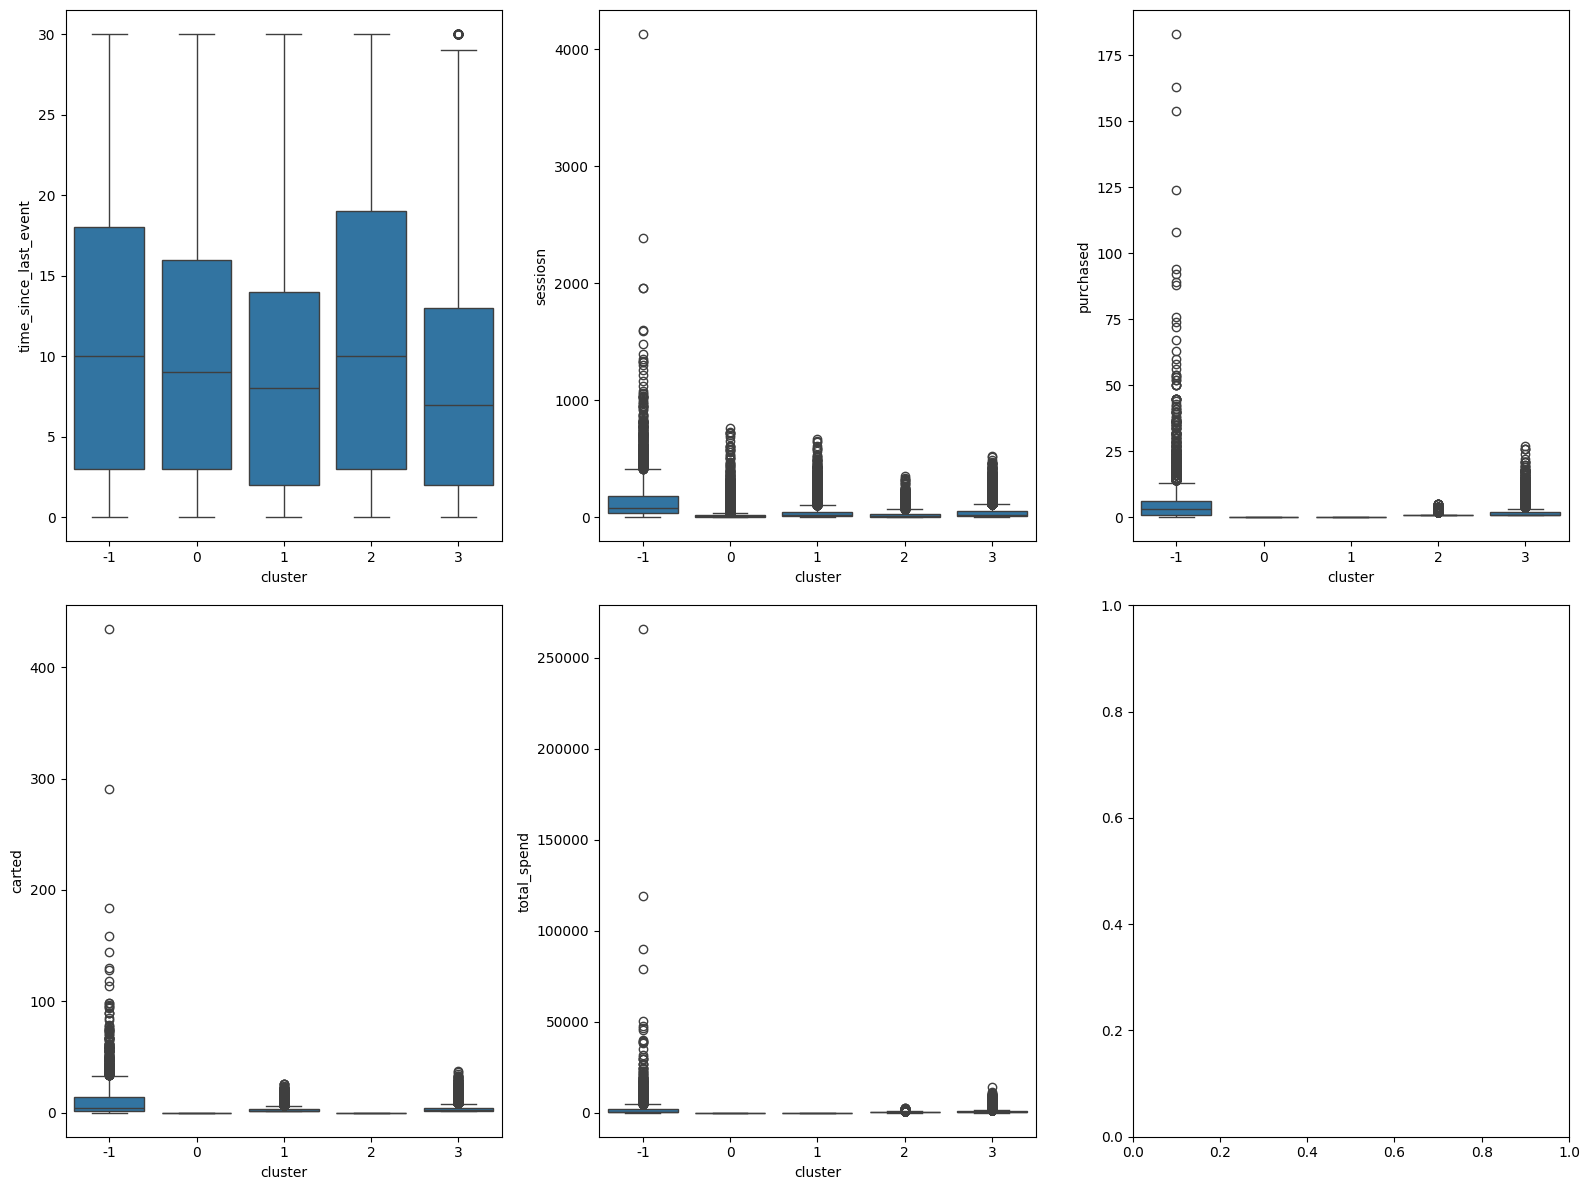

In [87]:
import seaborn as sns
categories = analysis.drop(['user_id', 'activity', 'log_sessions', 'log_purchased', 'log_carted', 'log_spend', 'labels', 'most_viewed_category_code', 'most_viewed_brand'], axis=1).columns
labels = analysis['labels']
categories
fig, axes = plt.subplots(2, 3, figsize=(16, 12))
axes = axes.ravel()

for i, cat in enumerate(categories):
    sns.boxplot(x=labels, y=analysis[cat], ax=axes[i])
    axes[i].set_xlabel('cluster')
    axes[i].set_label(cat)
plt.tight_layout()
plt.show()

In [54]:
import warnings
warnings.filterwarnings('ignore')
n_iter = 100
num_clusters = []
mean_spend = []
number_of_sessions = []
times_purchased = []
times_carted = []
top_spend = []

for i, n in enumerate(range(n_iter)):
    if i % 5 == 0:
        print(f'итерация {i}')
    tmp = df[df['activity'] != 'non-active']
    sample = tmp.groupby('activity', group_keys=False).apply(lambda x: x.sample(frac=0.05))
    sample['log_sessions'] = np.log1p(sample['number_of_sessions'])
    sample['log_purchased'] = np.log1p(sample['times_purchased'])
    sample['log_carted'] = np.log1p(sample['times_carted'])
    sample['log_spend'] = np.log1p(sample['total_spend'])
    analysis = sample.drop(['times_purchased', 'number_of_sessions', 'times_carted', 'total_spend'], axis=1)
    
    dbscan = HDBSCAN(min_cluster_size=100, min_samples=50, cluster_selection_epsilon=0.1, gen_min_span_tree=True)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(analysis.drop(['activity', 'user_id', 'most_viewed_category_code', 'most_viewed_brand', ], axis=1))
    dbscan.fit(scaled)

    labels = dbscan.labels_
    n_cluster = labels.max() + 1

    analysis['labels'] = labels
    analysis['sessiosn'] = np.expm1(analysis['log_sessions'])
    analysis['purchased'] = np.expm1(analysis['log_purchased'])
    analysis['carted'] = np.expm1(analysis['log_carted'])
    analysis['total_spend'] = np.expm1(analysis['log_spend'])
    stats = analysis.groupby('labels').agg(
    mean_sessions=('sessiosn', 'median'),
    mean_purchased=('purchased', 'median'),
    mean_carted=('carted', 'median'),
    mean_spend=('total_spend', 'median'),
    quart_spend=('total_spend', lambda x: np.quantile(x, 0.25)),
    top_spend=('total_spend', lambda x: np.quantile(x, 0.99)),
    mean_last_activity=('time_since_last_event', 'mean'),
    most_popular_brand=('most_viewed_brand', lambda x: x.mode()[0]),
    most_popular_category=('most_viewed_category_code', lambda x: x.mode()[0])
    )

    num_clusters.append(n_cluster)
    mean_spend.append(stats['mean_spend'].to_dict())
    number_of_sessions.append(stats['mean_sessions'].to_dict())
    times_purchased.append(stats['mean_purchased'].to_dict())
    times_carted.append(stats['mean_carted'].to_dict())
    top_spend.append(stats['top_spend'].to_dict())

итерация 0
итерация 5
итерация 10
итерация 15
итерация 20
итерация 25
итерация 30
итерация 35
итерация 40
итерация 45
итерация 50
итерация 55
итерация 60
итерация 65
итерация 70
итерация 75
итерация 80
итерация 85
итерация 90
итерация 95


(array([ 3., 40., 23., 20.,  7.,  6.,  1.]),
 array([2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9. ]),
 <BarContainer object of 7 artists>)

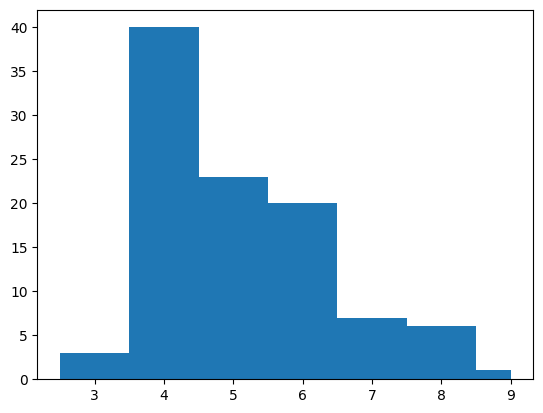

In [58]:
plt.hist(num_clusters, bins=[2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9])

<Axes: ylabel='total_spend'>

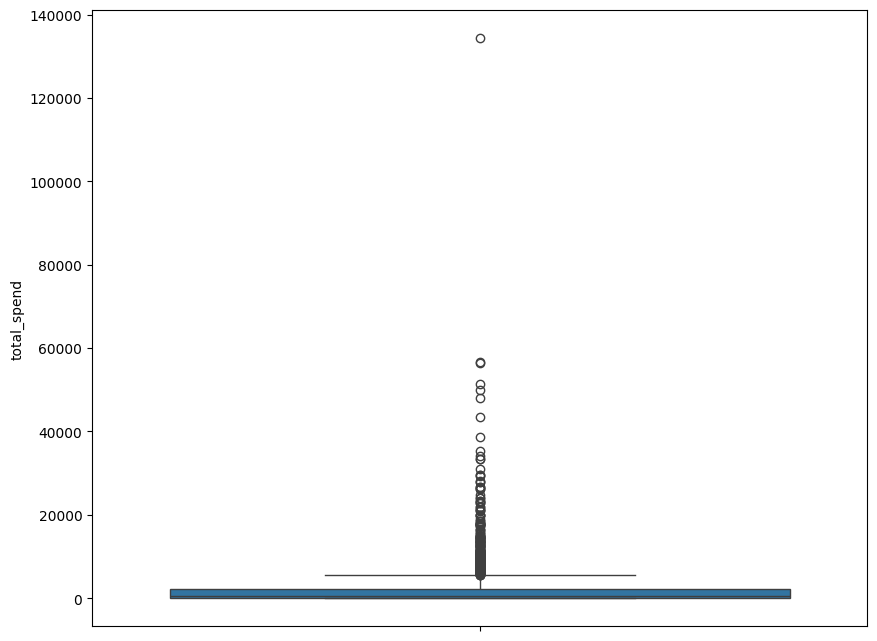

In [32]:
fig = plt.figure(figsize=(10, 8))
sus_group = analysis[analysis['labels'] == -1]
sns.boxplot(data=sus_group, y='total_spend')

In [33]:
print('0.1 and 0.9 quantiles:')
print(sus_group['total_spend'].quantile([0.1, 0.9]))
print(f'median {sus_group['total_spend'].median()}')

0.1 and 0.9 quantiles:
0.1       5.914001
0.9    5553.954004
Name: total_spend, dtype: float64
median 586.6900634765625


In [34]:
def classify_user(row):
    if row['labels'] != -1:
        return f"Standard Segment {row['labels']}"

    else:
        if row['total_spend'] >= sus_group['total_spend'].quantile(0.9):
            return "Elite (Outliers)"
        elif row['total_spend'] >= sus_group['total_spend'].median():
            return "High Value"
        else:
            return "Low Value Noise"

analysis['final_segment'] = analysis.apply(classify_user, axis=1)
analysis.head()

,user_id,most_viewed_category_code,most_viewed_brand,time_since_last_event,activity,log_sessions,log_purchased,log_carted,log_spend,labels,sessiosn,purchased,carted,total_spend,final_segment
60974,532360401,MISSING,lucente,22,active,2.890372,0.0,0.0,0.0,1,17.0,0.0,0.0,0.0,Standard Segment 1
279521,529809192,MISSING,hankook,13,active,2.197225,0.0,0.0,0.0,1,8.0,0.0,0.0,0.0,Standard Segment 1
2131679,513300725,electronics.tablet,samsung,2,active,2.639057,0.0,0.0,0.0,1,13.0,0.0,0.0,0.0,Standard Segment 1
839265,512626414,MISSING,janome,0,active,2.833213,0.0,0.0,0.0,1,16.0,0.0,0.0,0.0,Standard Segment 1
800129,562922509,computers.notebook,xiaomi,8,active,2.302585,0.0,0.0,0.0,1,9.0,0.0,0.0,0.0,Standard Segment 1


In [38]:
client.query(
'''
create table if not exists clusters (
    user_id int,
    cluster text,
    primary key (user_id)
) engine = MergeTree()
order by user_id
'''
)

In [35]:
from hdbscan import approximate_predict
df['log_sessions'] = np.log1p(df['number_of_sessions'])
df['log_purchased'] = np.log1p(df['times_purchased'])
df['log_carted'] = np.log1p(df['times_carted'])
df['log_spend'] = np.log1p(df['total_spend'])
t = df.drop(['times_purchased', 'number_of_sessions', 'times_carted', 'total_spend'], axis=1)
scale = scaler.transform(t.drop(['user_id', 'most_viewed_brand', 'most_viewed_category_code', 'activity'], axis=1))
print(t.columns)
res = approximate_predict(dbscan, scale)
res

Index(['user_id', 'most_viewed_category_code', 'most_viewed_brand',
       'time_since_last_event', 'activity', 'log_sessions', 'log_purchased',
       'log_carted', 'log_spend'],
      dtype='object')


(array([1, 3, 1, ..., 1, 1, 1], shape=(6718407,), dtype=int32),
 array([1.        , 1.        , 1.        , ..., 0.33631502, 1.        ,
        1.        ], shape=(6718407,)))

In [36]:
t['labels'] = res[0]
t['total_spend'] = np.expm1(t['log_spend'])
t['segment'] = t.apply(classify_user, axis=1)
t.head()

,user_id,most_viewed_category_code,most_viewed_brand,time_since_last_event,activity,log_sessions,log_purchased,log_carted,log_spend,labels,total_spend,segment
0,562163470,appliances.kitchen.hob,bosch,0,active,3.526361,0.000000,0.000000,0.000000,1,0.000000,Standard Segment 1
1,562163482,electronics.smartphone,samsung,2,buyer,3.737670,1.098612,1.386294,5.965685,3,388.819916,Standard Segment 3
2,562163488,electronics.smartphone,xiaomi,10,active,2.397895,0.000000,0.000000,0.000000,1,0.000000,Standard Segment 1
3,562163497,MISSING,omron,10,non-active,1.098612,0.000000,0.000000,0.000000,1,0.000000,Standard Segment 1
4,562163499,electronics.smartphone,samsung,11,non-active,1.098612,0.000000,0.000000,0.000000,1,0.000000,Standard Segment 1


In [37]:
client.insert('clusters', t[['user_id', 'segment']])

In [39]:
client.query_df('''
    select * from clusters
''')

,user_id,cluster
0,517441398,Standard Segment 1
1,517441404,Standard Segment 2
2,517441404,Standard Segment 1
3,517441411,Standard Segment 1
4,517441413,Standard Segment 1
...,...,...
6718402,522282516,Standard Segment 3
6718403,522282570,Standard Segment 3
6718404,522282570,Standard Segment 3
6718405,522282619,Standard Segment 1


In [40]:
import joblib
import os

parent_dir = os.path.dirname(os.getcwd())
models_dir = os.path.join(parent_dir, 'models')

os.makedirs(models_dir, exist_ok=True)
joblib.dump(scaler, os.path.join(models_dir, 'scaler.pkl'))
joblib.dump(dbscan, os.path.join(models_dir, 'clusterer.pkl'))

['d:\\eCommerce\\models\\clusterer.pkl']

C:\Users\danil\AppData\Local\Temp\ipykernel_33312\995034371.py:15: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 500)
C:\Users\danil\AppData\Local\Temp\ipykernel_33312\995034371.py:16: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 12000)


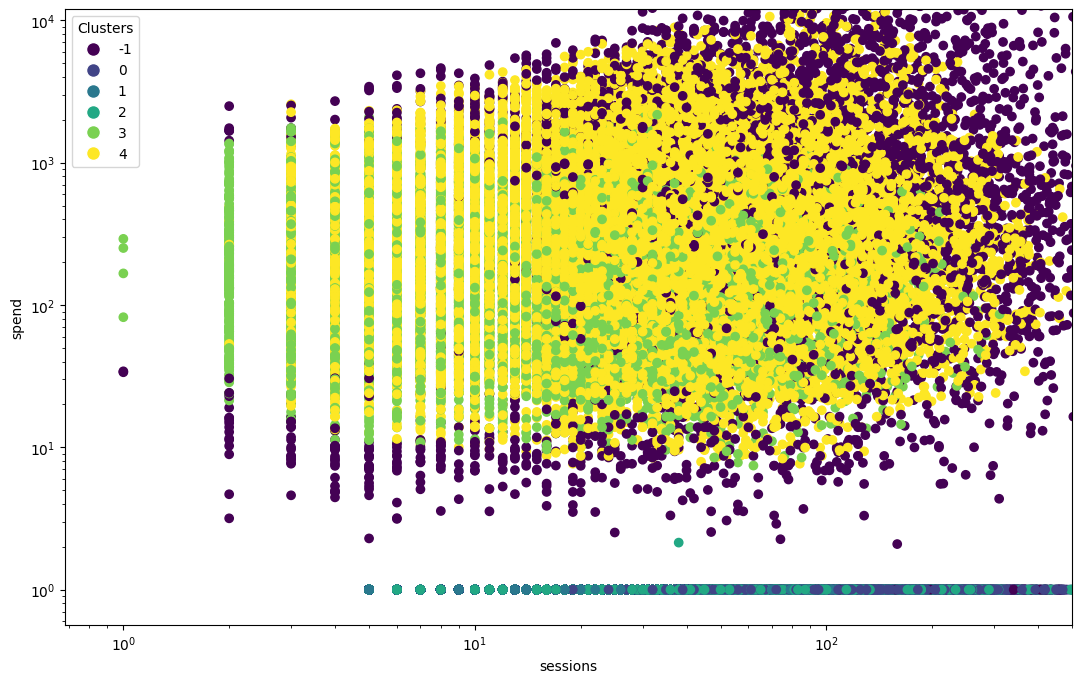

In [74]:
plt.figure(figsize=(13, 8))
sc = plt.scatter(x=analysis['sessiosn'], y=analysis['total_spend'] + 1, c=analysis['labels'], cmap='viridis')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('sessions')
plt.ylabel('spend')
unique_labels = analysis['labels'].unique()

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label=f'{label}',
               markerfacecolor=sc.cmap(sc.norm(label)), markersize=10)
    for label in sorted(unique_labels)
]

plt.xlim(0, 500)
plt.ylim(0, 12000)

plt.legend(handles=legend_elements, title="Clusters")
plt.show()

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=0)
proj = tsne.fit_transform(analysis.drop(['activity', 'user_id'], axis=1))

KeyboardInterrupt: 

In [ ]:
class ConvertColsToInt(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_process=['most_viewed_brand'], map_string='brand'):
        self.cols_to_process = cols_to_process
        self.map_string = map_string
        self.top_values_dict = {}

    def fit(self, df):

        df = df.copy()
        for c in self.cols_to_process:
            if c in df.columns:
                cnt = df[c].value_counts().sort_values(ascending=False).reset_index()[:20]
                self.top_values_dict[c] = set(cnt.iloc[:, 0])
            else:
                self.top_values_dict[c] = set()
        
        return self
    
    def transform(self, df):

        df = df.copy()
        if 'most_viewed_category_code' in df.columns:
            df['category'] = df['most_viewed_category_code'].apply(lambda x: x.split('.')[0])
            df = df.drop('most_viewed_category_code', axis=1)
        
        for c in self.cols_to_process:
             if c in df.columns:
                col_mapping = self.top_values_dict.get(c, set())
                df[c] = df[c].apply(lambda x: x if x in col_mapping else f'niche {self.map_string}')
        
        cols_to_encode = self.cols_to_process + ['category']
        for c in cols_to_encode:
            dummies = pd.get_dummies(df[c], prefix=f'{c}', drop_first=True, dtype=int)
            df = pd.concat([df, dummies], axis=1)
            df = df.drop(c, axis=1)
        
        return df

In [ ]:
converter = ConvertColsToInt()

pipeline = Pipeline([
    ('convert', converter),
    ('scaler', MinMaxScaler()),
    ('dbscan', HDBSCAN())
])

In [ ]:
pipeline.fit(df)

KeyboardInterrupt: 